# Multiclass Logistic Regression

## Preliminaries

### Imports

In [1]:
from copy import copy

import numpy as np
import numpy.random as random
import pandas as pd

import scipy.optimize as optimize
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="white", color_codes=True)

import sys
sys.path.append("../..")
from E4525_ML.multiclass_logistic import LogisticGDClassifier

### Random Seed

In [2]:
seed=12759
random.seed(seed)

## Logistic Multiclass Loss and Gradient

### Clas Probabilities
For multi-label classification problems we asume $Y|_X$ is a categorical variable with $K$ classes.

The logistic model asumes that the categorical variable **class probabilities** are
\begin{equation}
		\theta_k(x) = \textrm{softmax}_k(\eta(x))
\end{equation}
were  we define  the `logits` variables $\eta$ as depending linearly on $x$
\begin{equation}
		\eta(x) = W^T x + b
\end{equation}
or, writing all the indexes explicitly
\begin{equation}
    \eta_k(x) = \sum_d W_{d,k} x_d + b_k
\end{equation}
where we have explicitly highlited the bias term $b$, instead of absorbing it on $W$.

The function `softmax` is defined as
\begin{equation}
	\theta_k(\eta)=\textrm{softmax}_k(\eta) = \frac{ e^{\eta_k}}{\sum_{k'} e^{\eta_{k'}}}
\end{equation}

To avoid numerical accuracy problems with the exponential of very large numbers, we multiple and divide
the `softmax` expresion by the exponential of 
$$
    \bar{\eta} = \max_k \eta_k
$$
so that $\theta_k$ becomes
\begin{equation}
	\theta_k(\eta)=\textrm{softmax}_k(\eta) = \frac{ e^{\eta_k-\bar{\eta}}}{\sum_{k'} e^{\eta_{k'}-\bar{\eta}}}
\end{equation}
where the largest term in the denominator sum will be $1$.


In [3]:
def logisticClassProbability(X,b,W):
    logits=X.dot(W.T)+b
    elogits=np.exp(logits-logits.max(axis=1)[:,np.newaxis]) # make calculation more stable numerically
    elogits_sum=elogits.sum(axis=1)
    class_probs=elogits/elogits_sum[:,np.newaxis]
    return class_probs

### Logistic Cross Entropy Loss 

  The maximum likelihood loss is given by
  
  $$
      E(b,W;\{x_i,y_i\}) = -\sum_i \sum_k z_{i,k} \log \theta_k(\eta(x_i))
  $$
  
  [Note] We have dropped a factor of $\frac{1}{N}$ from the loss relative to the class notes that does not affect the solution.

In [4]:
def logisticLoss(X,Z,b,W):
    class_probs=logisticClassProbability(X,b,W)
    loss= np.sum(-(Z*np.log(np.maximum(class_probs,1e-10))).sum(axis=1))
    return loss

### Loss Gradient
For optimization we will also need the loss gradient

\begin{align}
    \frac{\partial E}{\partial b_k} &= \sum_i \theta_k(x_i) - z_{i,k} \\
    \frac{\partial E}{\partial W_{d,k}} &= \sum_i \left( \theta_k(x_i) - z_{i,k}\right) x_{i,d}
 \end{align}

In [5]:
def logisticGradient(X,Z,b,W):
    class_probs=logisticClassProbability(X,b,W)
    delta=(Z-class_probs)
    return -delta.sum(axis=0),-np.dot(delta.T,X)

### Objective function for optimization

We will include a regularization penalty
$$
    \Omega(W) = \frac{\lambda}{2}\sum_{k,d} W_{d,k}^2
$$ 
in the objective function. We do not include a penalty on $b$ to assure that the class predicted class probabilities match the empirical class frequencies
$$
        \sum_i \theta_k(x_i) = \sum_i z_{i,k}
$$
With that extra term we have to optimize the objective function $L$ given by

\begin{align}
    L(b,W;\{x_i,y_i\}) &= E(b,W;\{x_i,y_i\}) + \lambda \frac{1}{2}\sum_{d,k} W_{k,d}^2 \\
    \frac{\partial L}{\partial b_k} &= \frac{\partial E}{\partial b_k} \\
    \frac{\partial L}{\partial W_{d,k}} &= \frac{\partial E}{\partial W_{d,k}} + \lambda W_{k,d}
\end{align}

[Note] the optimization package optimizes over a single vector $x$, so we need to flatten $b,W$ into
$$
x = ( b_1, \dots b_K,W_{1,1,}, \dots W_{D,K} )
$$
and similarly for gradients
$$
    \frac{\partial L}{\partial x} = \left( 
       \frac{\partial L}{\partial b_1},\dots, \frac{\partial L}{\partial b_K},
       \frac{\partial L}{\partial W_{1,1}},\dots,\frac{\partial L}{\partial W_{D,K}}
       \right) 
$$

In [47]:
def val_func(x0,X,Z,penalty):
    D=X.shape[1]
    K=Z.shape[1]
    b=x0[:K]
    W=x0[K:].reshape((K,D))
    loss=logisticLoss(X,Z,b,W)
    if penalty>0:
        loss+=0.5*penalty*(W**2).sum()
    return loss

def grad_func(x0,X,Z,penalty):
    D=X.shape[1]
    K=Z.shape[1]
    b=x0[:K]
    W=x0[K:].reshape((K,D))
    gradb,gradW=logisticGradient(X,Z,b,W)
    if penalty>0: # optimization, do not perform the sum if penalty==0 
        gradW+=penalty*W
    # we return first the gradient relative to $b$ and then to $W$
    return np.concatenate([gradb,gradW.ravel()])

### Check Gradient

In [7]:
X=np.array([[0,1,2,3,4],
            [1,2,3,4,5],
            [2,3,4,5,6],
            [3,4,5,6,7],          
           ])


In [8]:
Z=np.array([[0,0,1],
            [1,0,0],
            [0,1,0],
            [1,0,0]
           ])

In [9]:
W=np.array([[1,0.1,0.1,0.0,0.1],
            [0.1,1,0.2,0.1,0.3],
            [-.1,-0.2,1.2,0.2,-2]])
W.shape

(3, 5)

In [10]:
b=np.array([0.0,-2.0,2.0])
b.shape

(3,)

In [11]:
penalty=0

In [12]:
x0=np.concatenate([b,W.ravel()])
x0

array([ 0. , -2. ,  2. ,  1. ,  0.1,  0.1,  0. ,  0.1,  0.1,  1. ,  0.2,
        0.1,  0.3, -0.1, -0.2,  1.2,  0.2, -2. ])

In [13]:
optimize.approx_fprime(x0,val_func,1e-8,X,Z,penalty)

array([-7.33098116e-01,  1.72320185e+00, -9.90103732e-01, -2.51464574e+00,
       -3.24774385e+00, -3.98084223e+00, -4.71394035e+00, -5.44703838e+00,
        2.51370160e+00,  4.23690345e+00,  5.96010521e+00,  7.68330723e+00,
        9.40650899e+00,  9.44133660e-04, -9.89159599e-01, -1.97926324e+00,
       -2.96936697e+00, -3.95947053e+00])

In [14]:
optimize.check_grad(val_func,grad_func,x0,X,Z,penalty)

3.8437902120324466e-07

## Generate Random Samples

### Training Data

In [15]:
D=2
K=4
N=100

In [16]:
mu=np.array([0.0,0.0])
cov=np.array([[1.0,0.7],
              [0.7,1.0]
             ])

In [17]:
W0=np.array([
             [10.0,0.0 ],
             [0.0, 5.0],
             [5.0,5.0],
             [5.0,-5.0]
            ]
           )
b0=np.array([0.,0.0,2.,0.0])

In [18]:
bW0=np.c_[b0,W0]

In [19]:
X=random.multivariate_normal(mu,cov,size=N)

In [20]:
X.mean(axis=0)

array([0.10871596, 0.22081613])

We generate samples that follow the logistic distribution. Given $x$, the one hot encoding $z$ of $y$ is generated as
$$
    Z(x) \sim \textrm{Categorical}(\theta(x))
$$
where the categorical distribution parameters are generated as
$$
    \theta_k(x) = \textrm{softmax}(\sum_{k,d}x_d W_{k,d} +b_k)=\textrm{softmax}(x W^T +b)
$$

In [21]:
def generate_logistic_multinomial(X,W,b):
    X1=np.c_[np.ones(len(X)),X]
    bW=np.c_[b,W]
    nu=np.dot(X1,bW.T)
    enu=np.exp(nu)
    enu_sum=enu.sum(axis=1)
    pi=enu/enu_sum[:,np.newaxis]
    Z=np.empty_like(pi)
    for i1 in range(len(pi)):
        Z[i1]=random.multinomial(1,pi[i1],1)
    return Z

In [22]:
Z=generate_logistic_multinomial(X,W0,b0)

In [23]:
Z.mean(axis=0)

array([0.13, 0.14, 0.47, 0.26])

In [24]:
Y=Z.argmax(axis=1)
Y[:100]

array([2, 0, 1, 2, 0, 1, 1, 3, 1, 2, 2, 3, 2, 2, 2, 2, 3, 0, 0, 0, 3, 2,
       2, 2, 2, 2, 3, 3, 2, 1, 3, 3, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 0,
       2, 0, 2, 3, 2, 3, 1, 3, 2, 1, 0, 3, 1, 2, 2, 3, 2, 3, 2, 3, 2, 3,
       3, 0, 1, 2, 2, 0, 2, 0, 3, 2, 2, 3, 2, 2, 2, 1, 3, 1, 2, 1, 1, 3,
       3, 0, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2])

In [25]:
data=pd.DataFrame(np.c_[Y,X],columns=["Y","X1","X2"])
data.head()

,Y,X1,X2
0,2.0,1.345100,2.007299
1,0.0,0.700666,-0.055637
2,1.0,-0.881124,0.036733
3,2.0,0.773288,0.408596
4,0.0,2.128024,0.890464


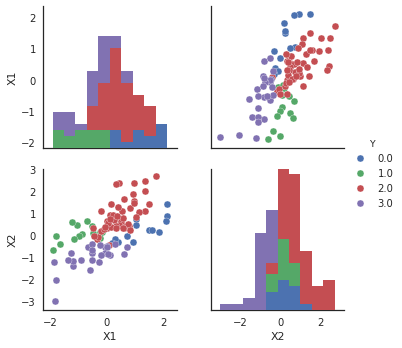

In [26]:
sns.pairplot(data,vars=["X1","X2"],hue="Y")

### Test Data

In [27]:
X_test=random.multivariate_normal(mu,cov,size=N)
Z_test=generate_logistic_multinomial(X_test,W0,b0)
Y_test=Z_test.argmax(axis=1)

## Parameter Optimization

### Logistic Regression using `scipy.optimize`

In [28]:
def optimize_logistic_weights_scipy(X,Z,b,W,penalty=0,
                                    method="newton-cg",
                                    tol=1e-16,
                                    max_iter=100):
    D=X.shape[1]
    K=Z.shape[1]
    x0=np.concatenate((b,W.ravel()))
   
    fit=optimize.minimize(val_func, x0, args=(X,Z,penalty),jac=grad_func,
             method=method,   
             tol=tol)
    x1=fit.x
    b=x1[:K]
    W=x1[K:].reshape((K,D))
    return b,W

### Test Scipy Optimizer

In [29]:
D=X.shape[1]
K=Z.shape[1]

In [30]:
b_guess=np.zeros(K)
W_guess=random.normal(0,1,(K,D))

In [31]:
b,W=optimize_logistic_weights_scipy(X,Z,b_guess,W_guess,penalty=0,tol=1e-4)
print(b,W)

[ 0.93690446  1.91172419  4.85650468 -7.70522182] [[  8.22743327   2.60067161]
 [ -7.74696288  10.68312869]
 [ -0.17658796  10.92849542]
 [  0.7383922  -24.82686834]]


### Stochastic Gradient Descent Optimizer

For each **epoch** ( a complete optimization run through all the training data) we:
1. Permute the input data.
2. Break input data in small size **mini-batches**
3. Update parameters on each mini-bath using the gradient descent update rule.
4. For convenience, we report losses in both training and valuation 10 times (once every 100 epochs) during optimization.

We repeate this procedure for `max_iter` number of epochs (**complete runs through all the training data**), or until we stop improving the lost function.

In [32]:
def report_function(e,params,X,Z,X_val,Z_val,penalty):
    D=X.shape[1]
    K=Z.shape[1]
    b=params[:K]
    W=params[K:].reshape((K,D))
    loss=val_func(params,X,Z,penalty)
    class_probs=logisticClassProbability(X,b,W)
    Y_pred=class_probs.argmax(axis=1) 
    Y=Z.argmax(axis=1)
    train_accuracy=np.mean(Y_pred==Y)
    print("\t",e,"Loss =",loss,"Train_Accuracy",train_accuracy,end=" ")
    if not(X_val is None): # if we have a valuation set we can report
                        # how well we are doing out of sample
        val_e=val_func(params,X_val,Z_val,penalty)
        class_probs=logisticClassProbability(X_val,b,W)
        Y_pred=class_probs.argmax(axis=1)          
        Y_val=Z_val.argmax(axis=1)     
        val_accuracy=np.mean(Y_pred==Y_val)
        print("Evaluation Loss =",val_e,"Accuracy =",val_accuracy)
    else:
        print()


### Logistic Regression using Stochastic Gradient Descent
def optimize_logistic_weights(X,Z,b,W,
                            X_val=None,
                            Z_val=None,
                            penalty=0,
                            learning_rate=0.01,
                            tol=1e-8,
                            max_iter=1000,
                            batch_size=100,
                            verbose=True
                              ):
    
    D=X.shape[1]
    K=Z.shape[1]
    x=np.concatenate((b,W.ravel()))
    if Z_val is not None:
        Y_val=Z_val.argmax(axis=1)
    N=len(X)
    l0=val_func(x,X,Z,penalty)
    for e in range(max_iter):
        if (e%(max_iter//10)==0 and verbose):
            report_function(e,x,X,Z,X_val,Z_val,penalty)
        perm=random.permutation(N)
        for i in range(0,N,batch_size):
            Xb=X[perm[i:i+batch_size]]
            Zb=Z[perm[i:i+batch_size]]
            p=len(Xb)/N*penalty
            grad=grad_func(x,Xb,Zb,p)
            x-=learning_rate*grad
        l=val_func(x,X,Z,penalty)
       
        d=np.abs(l-l0)
        if d<tol*l0:
            break
        l0=l  
    if verbose:
        report_function(e,x,X,Z,X_val,Z_val,penalty)
    b=x[:K]
    W=x[K:].reshape((K,D))
    return b,W   

In [33]:
b,W=optimize_logistic_weights(X,Z, b_guess,W_guess,
                             X_test, Z_test, 
                             penalty=0,learning_rate=0.001,batch_size=100,tol=1e-8)
print(b,W)

	 0 Loss = 299.2921064941822 Train_Accuracy 0.05 Evaluation Loss = 273.1162446159898 Accuracy = 0.11
	 100 Loss = 72.34669765799127 Train_Accuracy 0.78 Evaluation Loss = 80.87929782907966 Accuracy = 0.7
	 200 Loss = 53.63530808024932 Train_Accuracy 0.84 Evaluation Loss = 63.85907129598698 Accuracy = 0.72
	 300 Loss = 45.8091298397824 Train_Accuracy 0.84 Evaluation Loss = 57.744296293227386 Accuracy = 0.76
	 400 Loss = 41.410711569026525 Train_Accuracy 0.85 Evaluation Loss = 54.553172968296245 Accuracy = 0.79
	 500 Loss = 38.53236686419029 Train_Accuracy 0.86 Evaluation Loss = 52.54732002480233 Accuracy = 0.81
	 600 Loss = 36.47627916788786 Train_Accuracy 0.86 Evaluation Loss = 51.15585696924866 Accuracy = 0.83
	 700 Loss = 34.92151578312621 Train_Accuracy 0.86 Evaluation Loss = 50.130045041659145 Accuracy = 0.83
	 800 Loss = 33.69772475180277 Train_Accuracy 0.86 Evaluation Loss = 49.34192724969121 Accuracy = 0.82
	 900 Loss = 32.705220657483146 Train_Accuracy 0.86 Evaluation Loss = 48.

### Training Sample Performance

In [34]:
pi=logisticClassProbability(X,b,W)

In [35]:
Y_pred=pi.argmax(axis=1)

In [36]:
np.mean(Y_pred==Y)

0.87

### Out of Sample Performance

In [37]:
pi=logisticClassProbability(X_test,b,W)

In [38]:
Y_pred=pi.argmax(axis=1)
np.mean(Y_pred==Y_test)

0.82

### Stochastic Gradient Descent Logistic Classifier Class

The convenience Stochastic Gradient descent classifier, sets defaults for most parameters, takes care of the one-hot encoding of $Y$, etc. and follows the sklearn `fit`/`predict` convention. 

In [39]:
class LogisticGDClassifier:
    def __init__(self,
        penalty=0,
        learning_rate=0.005,
        batch_size=100,
        tol=1e-4,
        max_iter=100,
        verbose=True
    ):
        self.penalty=penalty
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        self.tol=tol
        self.max_iter=max_iter
        self.verbose=verbose
    def fit(self,X,Y,X_val=None,Y_val=None):
        # X_val and Y_val are only used to report accuracy during optimization
        # they do not affect the fitted W,b parameters
        
        
        if X.ndim==1:
            X=X.reshape(1,-1)
        N,D=X.shape
       
        self.encoder=LabelEncoder()
        y=self.encoder.fit_transform(Y)      
        K=len(self.encoder.classes_)
        Z=np.zeros((N,K),dtype=int)
        Z[np.arange(N),y]=1
        
        
        if not(X_val is None):
            N_val=len(X_val)
            y_val=self.encoder.transform(Y_val)  
            Z_val=np.zeros((N_val,K),dtype=int)
            Z_val[np.arange(N_val),y_val]=1
        else: 
            Z_val=None

        b_guess=np.zeros(K)
        W_guess=random.normal(0,1,(K,D))/np.sqrt(D)
        
        self.b,self.W=optimize_logistic_weights(X,Z,b_guess,W_guess,
                                            X_val=X_val,
                                            Z_val=Z_val,
                                            penalty=self.penalty,
                                            learning_rate=self.learning_rate,
                                            batch_size=self.batch_size,
                                            tol=self.tol,
                                            max_iter=self.max_iter,
                                            verbose=self.verbose
                                            )
        
    def predict(self,X):
        if X.ndim==1:
            X=X.reshape(1,-1)
        N,D=X.shape   
        class_probs=logisticClassProbability(X,self.b,self.W)        
        y=class_probs.argmax(axis=1)
        return self.encoder.inverse_transform(y)
        


#### Stochastic Gradient Descent Optimizer

In [40]:
model=LogisticGDClassifier(penalty=0,learning_rate=0.01)


In [41]:
model.fit(X,Y,X_test,Y_test)

	 0 Loss = 128.29894338365216 Train_Accuracy 0.57 Evaluation Loss = 132.15145084663087 Accuracy = 0.48
	 10 Loss = 63.757558529039876 Train_Accuracy 0.77 Evaluation Loss = 72.95425487076339 Accuracy = 0.71
	 20 Loss = 50.8762247704224 Train_Accuracy 0.84 Evaluation Loss = 62.338037286007626 Accuracy = 0.76
	 30 Loss = 44.49847744119103 Train_Accuracy 0.85 Evaluation Loss = 57.37379469571593 Accuracy = 0.8
	 40 Loss = 40.62119802099522 Train_Accuracy 0.85 Evaluation Loss = 54.446865483458616 Accuracy = 0.81
	 50 Loss = 37.98487085923187 Train_Accuracy 0.86 Evaluation Loss = 52.51152480074172 Accuracy = 0.82
	 60 Loss = 36.06150792898946 Train_Accuracy 0.86 Evaluation Loss = 51.13786421370634 Accuracy = 0.83
	 70 Loss = 34.58851097144671 Train_Accuracy 0.86 Evaluation Loss = 50.11446132859266 Accuracy = 0.83
	 80 Loss = 33.41956450699294 Train_Accuracy 0.87 Evaluation Loss = 49.32469810892781 Accuracy = 0.82
	 90 Loss = 32.46626878173838 Train_Accuracy 0.86 Evaluation Loss = 48.698775271

In [42]:
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.82

#### Bayes Error Rate

As the data was generated using a logistic like process with parameters $W0$ and $b0$, the best
we han hope to achive is an error rate equal to the one computed with those parameters. 

This is known as the **Bayes error rate**

In [43]:
model0=copy(model)
model0.b=b0
model0.W=W0

In [44]:
Y_pred0=model0.predict(X_test)
np.mean(Y_pred0==Y_test)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.83

The best prediction accuracy we could expect is 84%

### Comparison to SKLearn

We can also use `sklearn` to create a multi class classifier, but **be careful**

In [45]:
model=LogisticRegression()
model.fit(X,Y)
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

0.73

Be default, the `sklearn` classifier uses regularization ($C=1$, equivalent to $\lambda=1$), and solves a **one versus rest** classification problem, not the full multi-class logistic regression problem.


**Corrected comparison**

In [46]:
model=LogisticRegression(C=1e30,multi_class="multinomial",solver="sag")
model.fit(X,Y)
Y_pred=model.predict(X_test)
np.mean(Y_pred==Y_test)

/home/manel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.82

Now results are equivalent to our own, and as good as they can possible be.